<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Описание-данных:" data-toc-modified-id="Описание-данных:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Описание данных:</a></span></li><li><span><a href="#Загрузка-библиотек:" data-toc-modified-id="Загрузка-библиотек:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка библиотек:</a></span></li><li><span><a href="#Загрузка-файлов:" data-toc-modified-id="Загрузка-файлов:-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Загрузка файлов:</a></span></li><li><span><a href="#Обзор-данных:" data-toc-modified-id="Обзор-данных:-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Обзор данных:</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Ресемплирование:" data-toc-modified-id="Ресемплирование:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Ресемплирование:</a></span></li><li><span><a href="#Trend,-Seasonality,-Residuals:" data-toc-modified-id="Trend,-Seasonality,-Residuals:-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Trend, Seasonality, Residuals:</a></span></li><li><span><a href="#Rolling-mean:" data-toc-modified-id="Rolling-mean:-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Rolling mean:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-дополнительных-признаков:" data-toc-modified-id="Создание-дополнительных-признаков:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание дополнительных признаков:</a></span></li><li><span><a href="#Подготовка-признаков:" data-toc-modified-id="Подготовка-признаков:-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подготовка признаков:</a></span></li><li><span><a href="#Линейная-регрессия:" data-toc-modified-id="Линейная-регрессия:-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Линейная регрессия:</a></span></li><li><span><a href="#Решающее-дерево:" data-toc-modified-id="Решающее-дерево:-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Решающее дерево:</a></span></li><li><span><a href="#CatBoost:" data-toc-modified-id="CatBoost:-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoost:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Описание данных:

**Исходные признаки:**

**datetime** - дата\
**num_orders** - номер заказа

### Загрузка библиотек:

In [719]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

### Загрузка файлов:

In [720]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

### Обзор данных:

In [721]:
def data_check (data_file):
    display(data_file.head())
    data_file.info()
    print('Количество пропусков', data_file.isna().sum().sum())
    print('Количество дубликатов:', sum(data_file.duplicated()))
    return 

In [722]:
data_check(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
Количество пропусков 0
Количество дубликатов: 26415


In [723]:
data.duplicated().sum()

26415

**Вывод:** Файл был загружен и проверен на наличие ошибок.

## Анализ

### Ресемплирование:

**Исходные данные:**

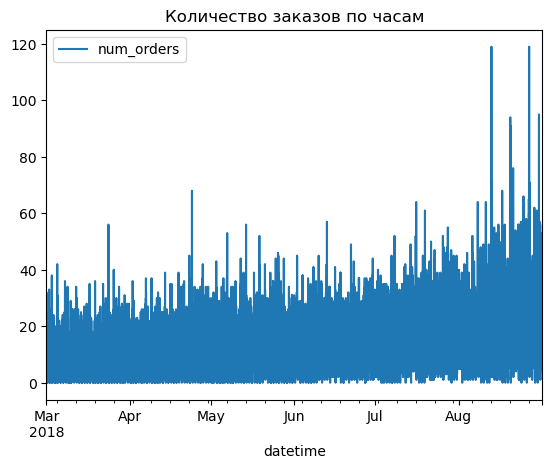

In [724]:
data.plot()
plt.title('Количество заказов по часам');

In [725]:
data.sort_index(inplace=True)

In [726]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [727]:
data_resample = data.resample('1H').sum()

**Полученные данные:**

In [728]:
data_resample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


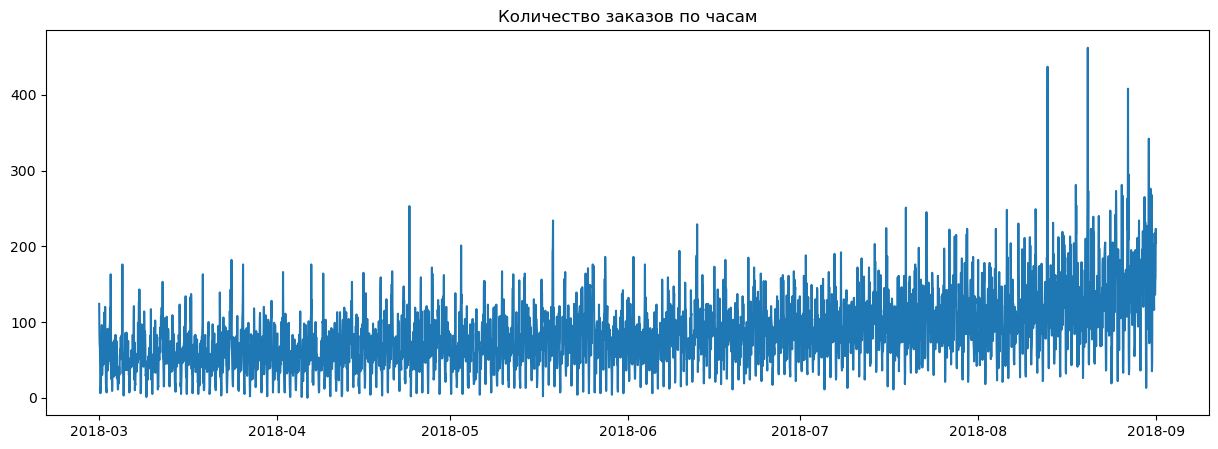

In [729]:
plt.figure(figsize=(15,5))
plt.title('Количество заказов по часам')
plt.plot(data_resample);

**Вывод:** Мы видим постепенный рост количеств заказов со временем. В этом можно будет позже убедиться, когда мы найдем скользящее среднее значение. Почему так происходит сказать сложно, возможно популярность сервиса растет, и количество пользователей соответсвенно тоже. Для того чтобы говорить о какой либо конкретной закономерности нехватает данных, хотя бы полностью годовой.

### Trend, Seasonality, Residuals:

In [730]:
decomposed = seasonal_decompose(data_resample)

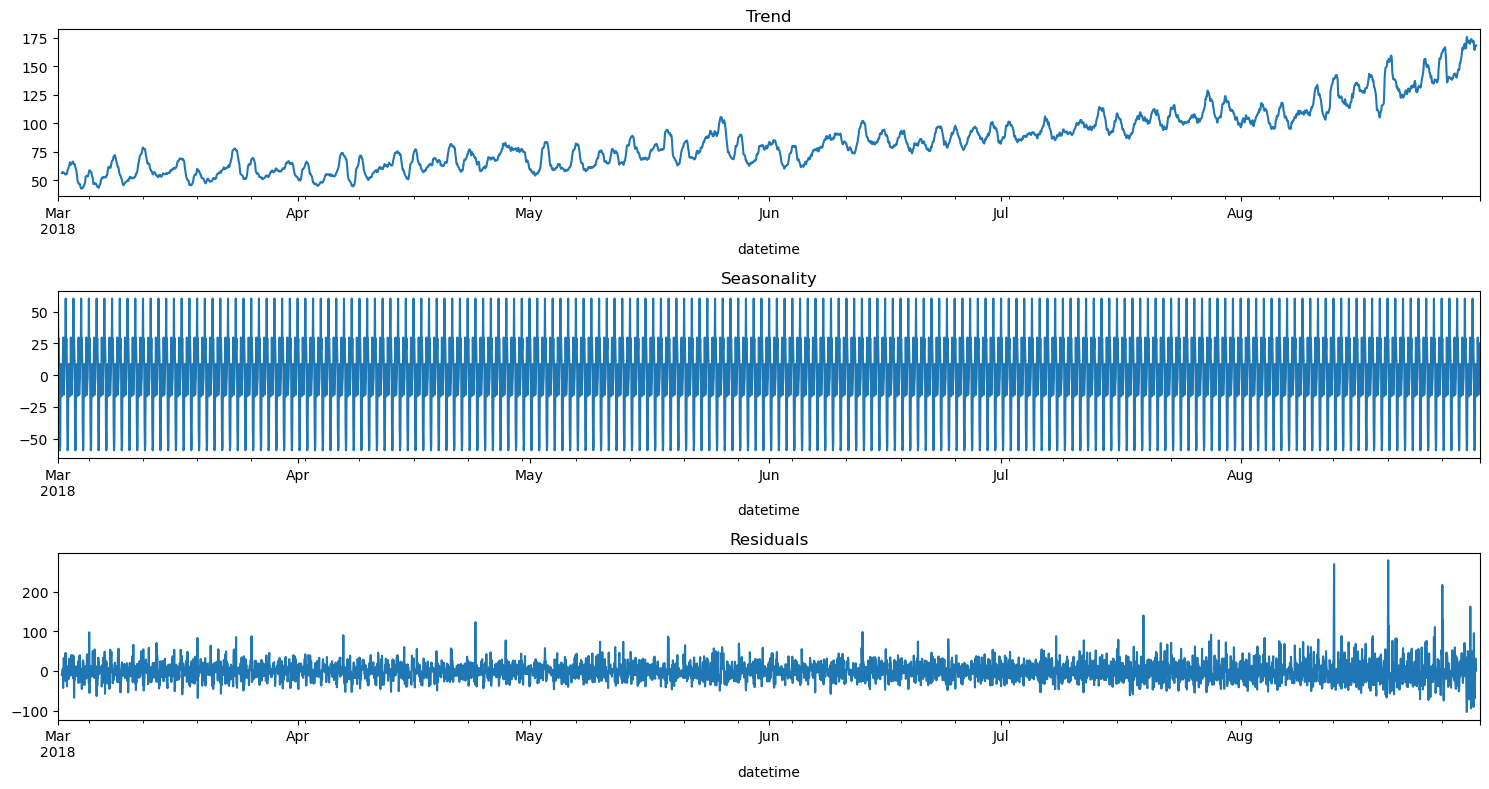

In [731]:
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Построим график за последний месяц, когда мы можем наблюдать рост тренда.

In [733]:
decomposed = seasonal_decompose(data_resample['2018-08-01':'2018-08-31'])

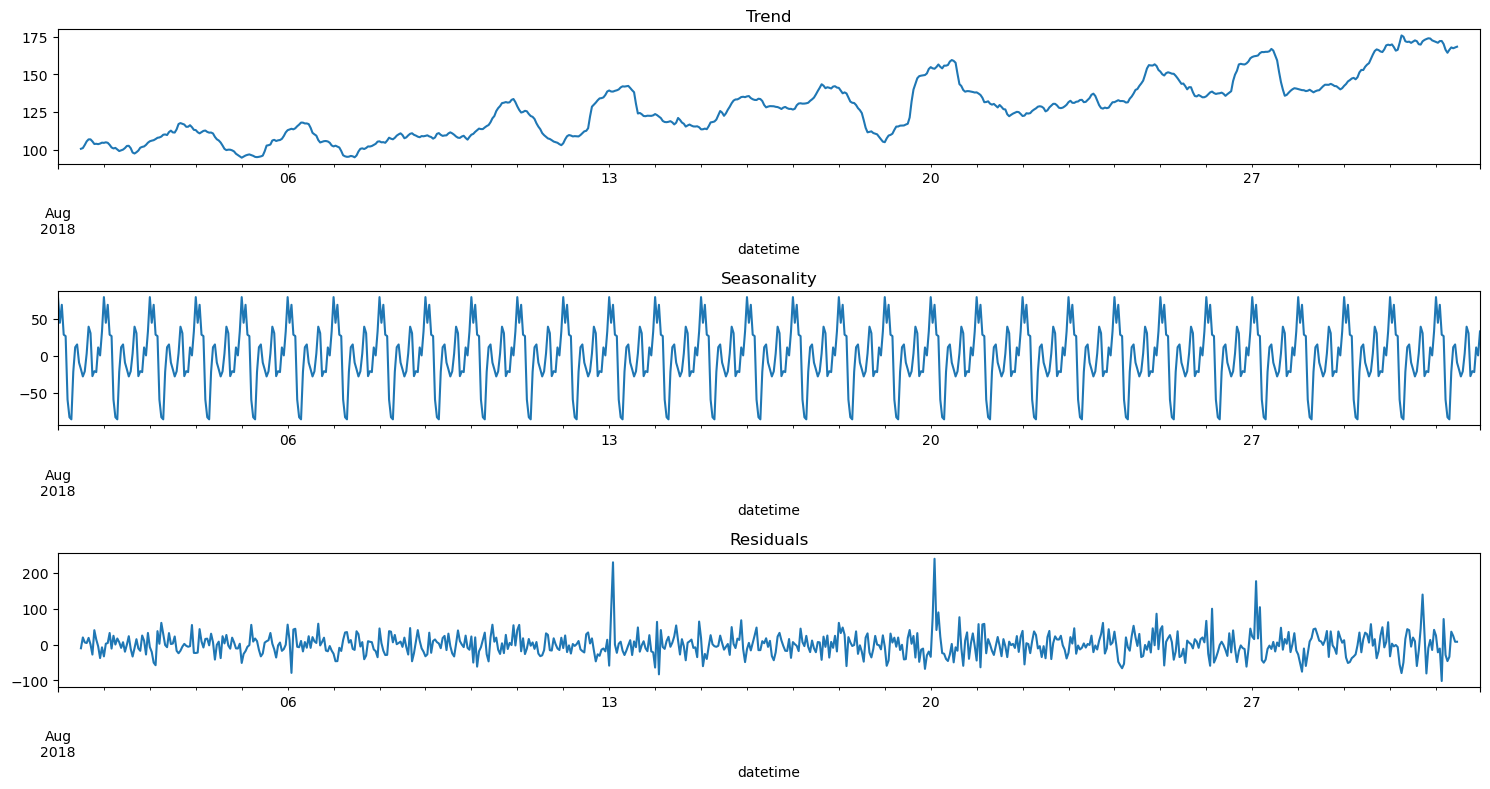

In [734]:
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

**Вывод:** Тренд так же показывает рост количества заказов за месяц и весь исследуемый период. По сезонности можно сделать вивод, что разлет количества заказов на каждый час суток примерно одинаковое. Ближе к вечеру спрос растет, когда как утром и в полдень количество обращений умеренное. 

In [735]:
decomposed = seasonal_decompose(data_resample['2018-08-01':'2018-08-07'])

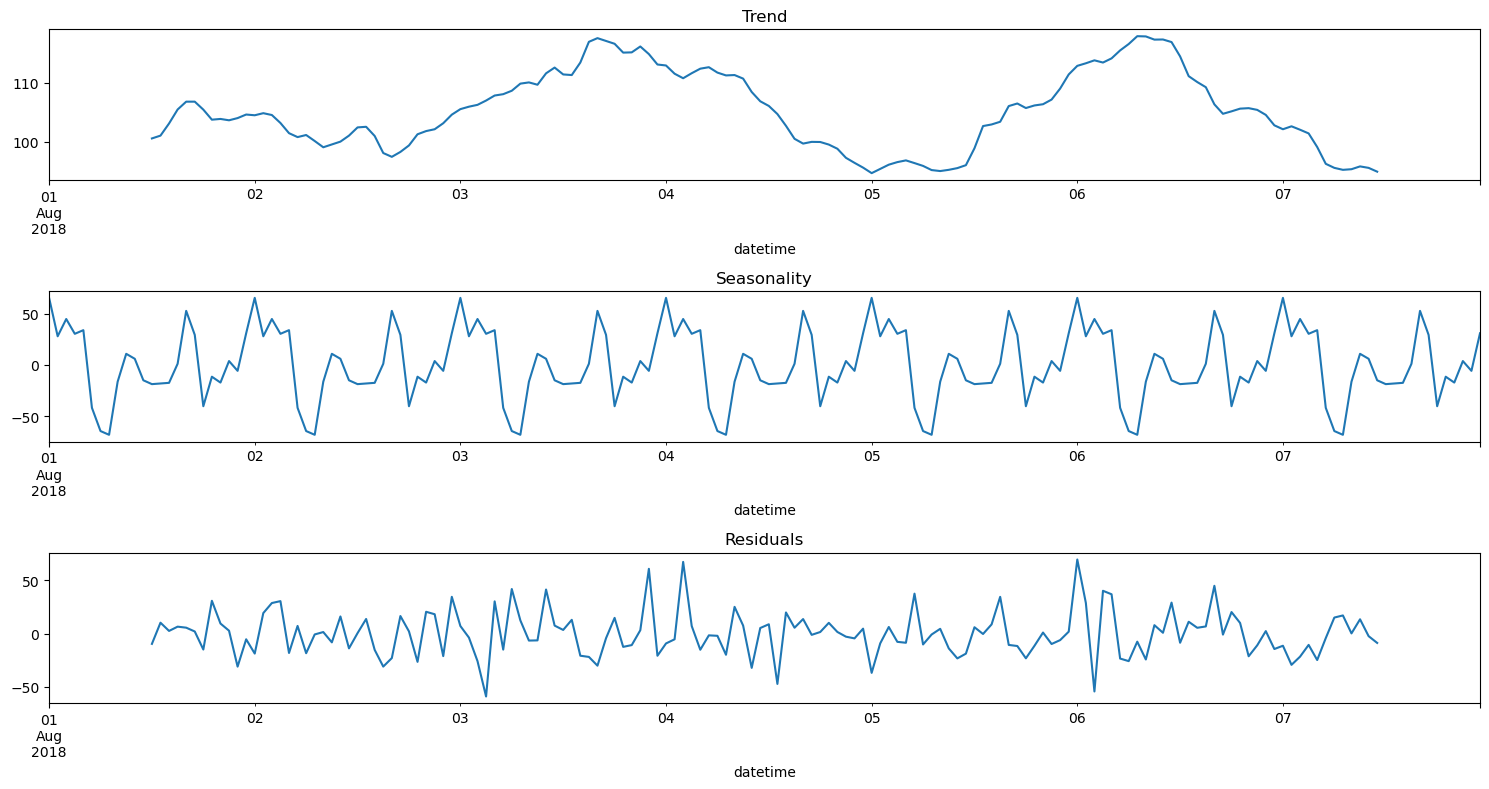

In [736]:
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

### Rolling mean:

Найдем скользящее среднее и посмотрим его на графике:

In [737]:
data_resample['rolling_mean'] = data_resample.rolling(10).mean()

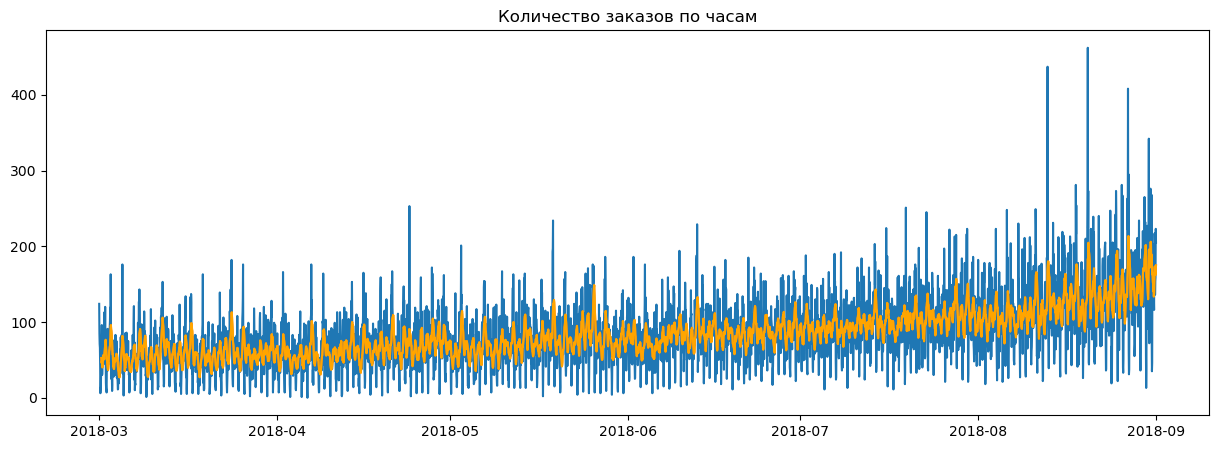

In [738]:
plt.figure(figsize=(15,5))
plt.title('Количество заказов по часам')
plt.plot(data_resample);
plt.plot(data_resample['rolling_mean'], "g", color='orange');

**Вывод:** По скользящему среднему так же можно сказать об общем росте заказов с каждым месяцем.

In [739]:
data_resample = data_resample.drop(['rolling_mean'], axis=1)

## Обучение

### Создание дополнительных признаков:

Исходя из показателей на графиках, можно предположить, что оптимальными для работы признаками послужат такие показатели как: час, день, месяц, скользящее среднее значение и значение лаг. Добавим в датасет данные признаки и начнем обучение модели.

In [740]:
def make_features(data_resample, max_lag, rolling_mean_size):
    data_resample['dayofweek'] = data_resample.index.dayofweek
    data_resample['day'] = data_resample.index.day
    data_resample['hour'] = data_resample.index.hour
    
    for lag in range(1, max_lag + 1):
        data_resample['lag_{}'.format(lag)] = data_resample['num_orders'].shift(lag)
        
    data_resample['rolling_mean'] = data_resample['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_resample    

In [741]:
make_features(data_resample, 24, 4)

,num_orders,dayofweek,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,31,19,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,184.25
2018-08-31 20:00:00,154,4,31,20,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,189.25
2018-08-31 21:00:00,159,4,31,21,154.0,136.0,207.0,217.0,197.0,116.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,178.50


In [742]:
try:
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]).resample('1H').sum()
except:
    taxi = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0]).resample('1H').sum()

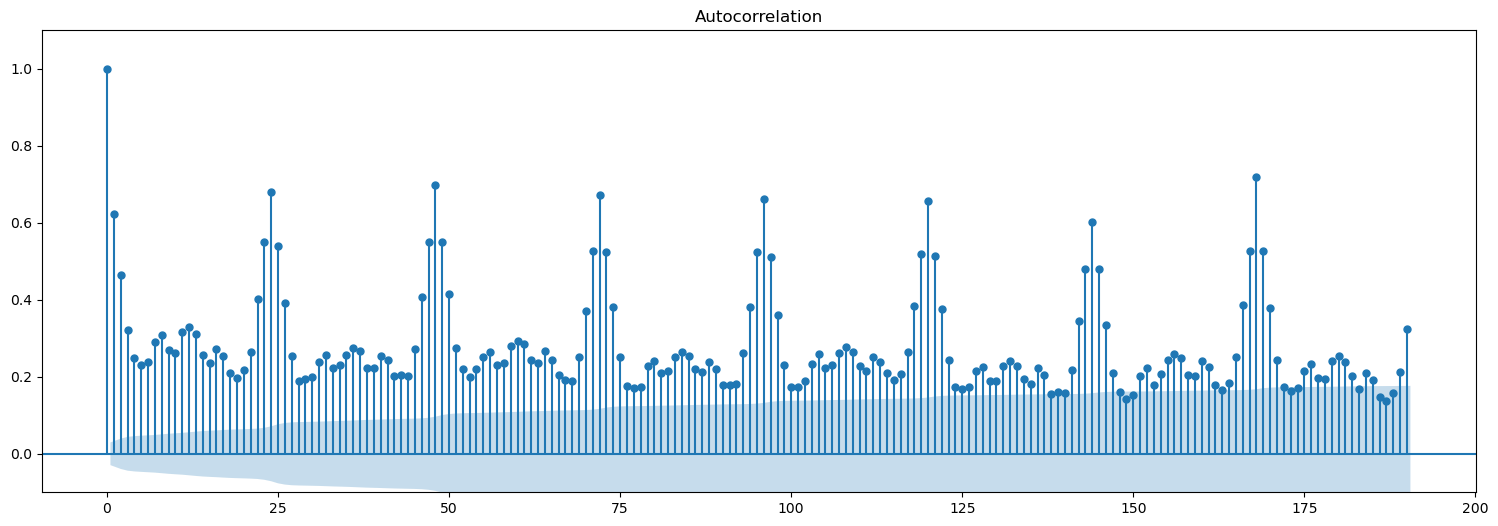

In [743]:
from statsmodels.graphics import tsaplots


ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

### Подготовка признаков:

In [744]:
train, test = train_test_split(data_resample, shuffle=False, test_size=0.1)

In [745]:
train = train.dropna()

In [746]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

In [747]:
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Линейная регрессия:

In [748]:
cv = TimeSeriesSplit(n_splits=3).split(features_train)
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
score_lr = cross_val_score(model_lr, features_train, target_train, scoring='neg_mean_squared_error', cv=cv)
print("RMSE обучающей выборки:", round(np.mean(-score_lr)**0.5, 2))

RMSE обучающей выборки: 27.99


### Решающее дерево:

In [749]:
cv = TimeSeriesSplit(n_splits=3).split(features_train)
model = DecisionTreeRegressor(random_state=12345)
model.fit(features_train, target_train)
scores = cross_val_score(model, features_train, target_train, scoring='neg_mean_squared_error', cv=cv)
print("RMSE обучающей выборки:", round(np.mean(-scores)**0.5, 2))

RMSE обучающей выборки: 36.68


### CatBoost:

In [750]:
%%time

model_Cat = CatBoostRegressor(verbose = 0, random_state = 12345)
hyperparams = [{'depth' : [3, 6, 9, 12],
                'learning_rate' : [0.1, 0.3, 0.5, 1],
                'iterations' : [100, 300, 500]
               }]
my_cv=TimeSeriesSplit(n_splits=3).split(features_train)
catbr = GridSearchCV(model_Cat, hyperparams, cv=my_cv, scoring='neg_root_mean_squared_error')
catbr.fit(features_train, target_train)
print('RMSE обучающей выборки:', catbr.best_score_)
print('Лучшие гиперпараметры', catbr.best_params_)

RMSE обучающей выборки: -26.041462952966683
Лучшие гиперпараметры {'depth': 6, 'iterations': 300, 'learning_rate': 0.1}
Wall time: 22min 54s


## Тестирование

**Протестируем модель LinearRegression:**

In [751]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
preds = model_lr.predict(features_test)
result = mean_squared_error(target_test, preds)
resultRMSE = result**0.5
print('RMSE на тестовой выборке:', resultRMSE)

RMSE на тестовой выборке: 45.16859297010219


**Протестируем модель DecisionTreeRegressor:**

In [752]:
cv = TimeSeriesSplit(n_splits=3).split(features_test)
model = DecisionTreeRegressor(random_state=12345)
model.fit(features_train, target_train)
scores = cross_val_score(model, features_test, target_test, scoring='neg_mean_squared_error', cv=cv)
print("RMSE обучающей выборки:", round(np.mean(-scores)**0.5, 2))

RMSE обучающей выборки: 62.71


**Протестируем модель CatBoostRegressor:**

In [753]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, depth=6)
model.fit(features_train, target_train)
preds = model.predict(features_test)
result = mean_squared_error(target_test, preds)
resultRMSE = result**0.5

0:	learn: 36.8378082	total: 3.22ms	remaining: 963ms
1:	learn: 35.1666849	total: 6.38ms	remaining: 951ms
2:	learn: 33.7756913	total: 9.22ms	remaining: 913ms
3:	learn: 32.4650912	total: 12ms	remaining: 885ms
4:	learn: 31.4004008	total: 14.6ms	remaining: 861ms
5:	learn: 30.4684529	total: 17.1ms	remaining: 837ms
6:	learn: 29.6342558	total: 19.6ms	remaining: 820ms
7:	learn: 28.9395583	total: 22.1ms	remaining: 805ms
8:	learn: 28.3273936	total: 24.7ms	remaining: 797ms
9:	learn: 27.7513996	total: 27.1ms	remaining: 787ms
10:	learn: 27.2706348	total: 29.7ms	remaining: 780ms
11:	learn: 26.8520007	total: 32.3ms	remaining: 774ms
12:	learn: 26.4539876	total: 34.8ms	remaining: 768ms
13:	learn: 26.0448939	total: 37.3ms	remaining: 762ms
14:	learn: 25.7103748	total: 39.8ms	remaining: 755ms
15:	learn: 25.4660170	total: 42.5ms	remaining: 754ms
16:	learn: 25.1715260	total: 45.3ms	remaining: 753ms
17:	learn: 24.9185622	total: 48ms	remaining: 752ms
18:	learn: 24.6916120	total: 50.6ms	remaining: 748ms
19:	lea

157:	learn: 17.7042491	total: 406ms	remaining: 365ms
158:	learn: 17.6762931	total: 409ms	remaining: 363ms
159:	learn: 17.6354035	total: 411ms	remaining: 360ms
160:	learn: 17.5985405	total: 414ms	remaining: 357ms
161:	learn: 17.5636648	total: 416ms	remaining: 355ms
162:	learn: 17.5129768	total: 419ms	remaining: 352ms
163:	learn: 17.4824710	total: 421ms	remaining: 349ms
164:	learn: 17.4587725	total: 424ms	remaining: 347ms
165:	learn: 17.4478438	total: 427ms	remaining: 344ms
166:	learn: 17.4130318	total: 429ms	remaining: 342ms
167:	learn: 17.3841839	total: 431ms	remaining: 339ms
168:	learn: 17.3434497	total: 434ms	remaining: 337ms
169:	learn: 17.3018539	total: 437ms	remaining: 334ms
170:	learn: 17.2776874	total: 440ms	remaining: 332ms
171:	learn: 17.2498549	total: 442ms	remaining: 329ms
172:	learn: 17.2163784	total: 445ms	remaining: 327ms
173:	learn: 17.1718126	total: 447ms	remaining: 324ms
174:	learn: 17.1280434	total: 450ms	remaining: 322ms
175:	learn: 17.0902757	total: 453ms	remaining:

In [754]:
print('RMSE на тестовой выборке:', resultRMSE)

RMSE на тестовой выборке: 40.45227475416476


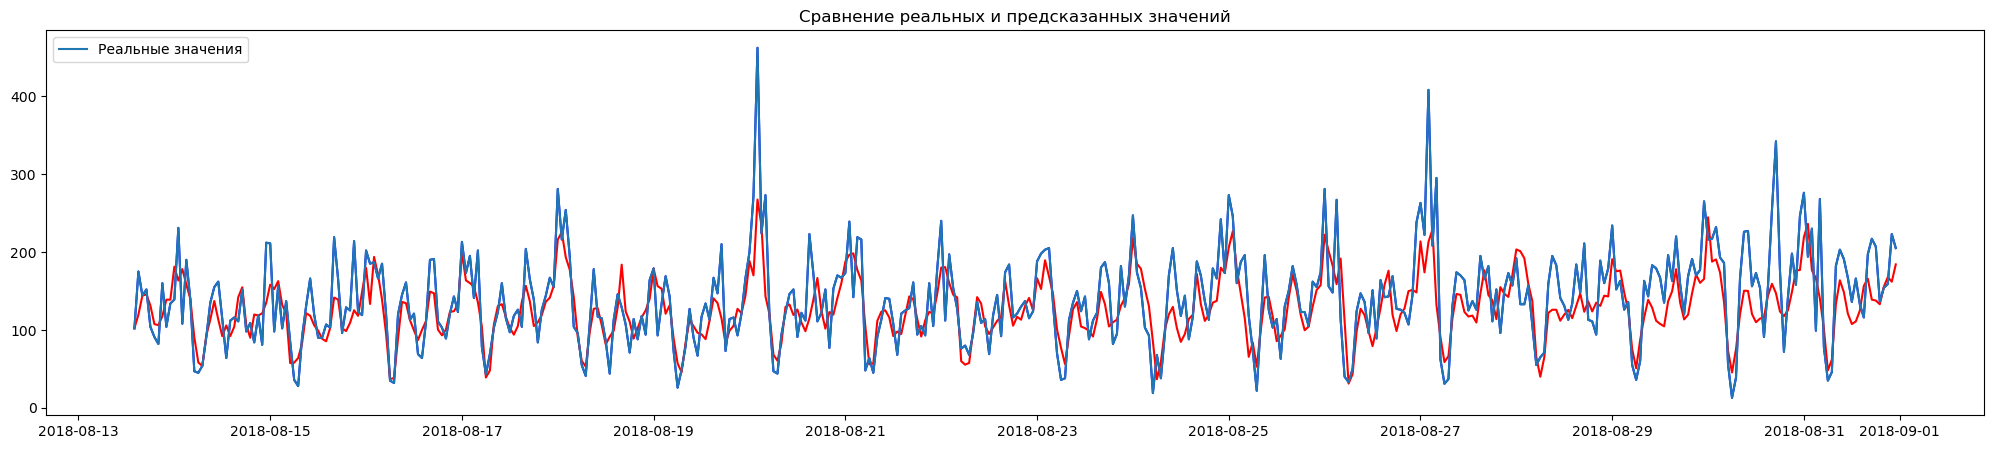

In [755]:
plt.figure(figsize=(25,5))
plt.title('Сравнение реальных и предсказанных значений')
plt.plot(target_test.index, target_test, 'b-', target_test.index, preds, 'r-');
plt.plot(target_test, label='Реальные значения')

plt.legend(loc="upper left");

In [756]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [757]:
data_resample = data.resample('1H').sum()

In [758]:
data_resample['rolling_mean'] = data_resample.rolling(6).mean()

In [759]:
def make_features_mod(data_resample, max_lag):
    data_resample['dayofweek'] = data_resample.index.dayofweek
    data_resample['day'] = data_resample.index.day
    data_resample['hour'] = data_resample.index.hour
    
    for lag in range(1, max_lag + 1):
        data_resample['lag_{}'.format(lag)] = data_resample['num_orders'].shift(lag)
        
    
    return data_resample    

In [760]:
make_features_mod(data, 168).head()

,num_orders,dayofweek,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,9,3,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 00:10:00,14,3,1,0,9.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 00:20:00,28,3,1,0,14.0,9.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 00:30:00,20,3,1,0,28.0,14.0,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 00:40:00,32,3,1,0,20.0,28.0,14.0,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


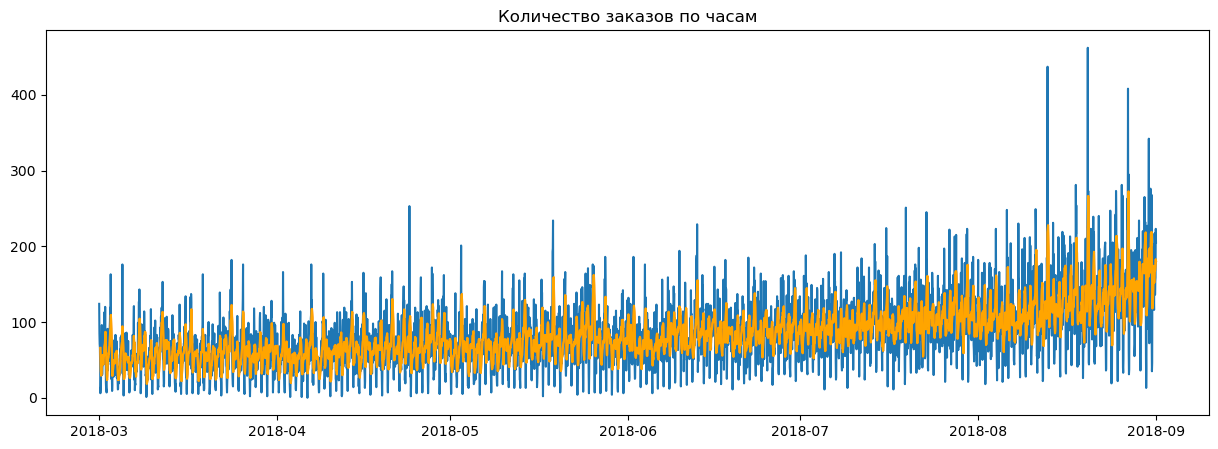

In [761]:
plt.figure(figsize=(15,5))
plt.title('Количество заказов по часам')
plt.plot(data_resample);
plt.plot(data_resample['rolling_mean'], "g", color='orange');

**Вывод V2:** Из трех опробованных на выборке моделей (LinearRegression, DecisionTreeRegressor, CatBoostRegressor), лучший результат показала модель CatBoost с метрикой RMSE: 47.37. По графику мы можем видеть, как предсказания почти идентичны реальным значениям, но с наличием ошибок, особенно под конец исследуемого периода. В датасете имеются выбросы с высокими значениями заказов в час, которые модель не может предсказать создавая погрешности. На обновленном графике заказов уже более наглядно видно, как в пиках модель пытается предсказать количество заказов, но на фоне всего разброса предсказаний это не так очевидно, что является спорным суждением. Можно попытаться компенсировать данную неопределенность и выделять больше ресурсов для удволетворения всех запросов, пусть даже они будут потенциальными. Выбросы повсторяются достаточно часто, с небольшой разницей во времени (плюс минус месяц), и которые могут зависеть от расписания полетов. Возможно в этот момент растет количество одновременно принимаемых или уходящих рейсов, а вместе с тем пассажиров, которые будут пользоваться услугами такси. Для того чтобы убедится в этом, нужно провести анализ расписания полетов. Возможно этот момент упускается в категории 'Residuals'.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48## Чек-лист проверки